In [4]:
#importing modules
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from shutil import copy2
import tensorflow
import IPython

import keras
keras.backend.clear_session()

In [12]:
#performing data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_dir='G:/btp data/Resized/top 400/exp3/train/'
validation_dir='G:/btp data/Resized/top 400/exp3/val/'
test_dir='G:/btp data/Resized/top 400/exp3/test/'

In [14]:
#loading data into generators
train_generator = train_datagen.flow_from_directory(
        train_dir,   
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=False,
        target_size=(224, 224),
        class_mode=None)

Found 8880 images belonging to 37 classes.
Found 2960 images belonging to 37 classes.
Found 2960 images belonging to 37 classes.


In [20]:
del model

In [21]:
#defining model's architecture
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras

initializer = keras.initializers.he_normal()
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer=initializer, input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(37, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [22]:
#defining metrics for our model
from keras.metrics import top_k_categorical_accuracy

def top3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy', top3_accuracy])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [24]:
#defining required callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, 
                                            patience=5, mode='auto',verbose=0, restore_best_weights=True)

checkpoint_path = "G:/btp data/Resized/top 400/exp3/checkpointcnn.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

In [25]:
#training our model for 150 epochs
historycnn = model.fit_generator(
      train_generator,
      epochs=150,
      validation_data=validation_generator,
      callbacks=[callback, cp_callback],
      verbose=1)

Epoch 1/150
278/278 [==============================] - ETA: 0s - loss: 14.2355 - accuracy: 0.0372 - top3_accuracy: 0.1011
Epoch 00001: saving model to G:/btp data/Resized/top 400/exp3/checkpointcnn.h5
278/278 [==============================] - 763s 3s/step - loss: 14.2355 - accuracy: 0.0372 - top3_accuracy: 0.1011 - val_loss: 14.0048 - val_accuracy: 0.0493 - val_top3_accuracy: 0.1422
Epoch 2/150
278/278 [==============================] - ETA: 0s - loss: 13.8283 - accuracy: 0.0609 - top3_accuracy: 0.1488
Epoch 00002: saving model to G:/btp data/Resized/top 400/exp3/checkpointcnn.h5
278/278 [==============================] - 328s 1s/step - loss: 13.8283 - accuracy: 0.0609 - top3_accuracy: 0.1488 - val_loss: 13.6151 - val_accuracy: 0.0713 - val_top3_accuracy: 0.1845
Epoch 3/150
278/278 [==============================] - ETA: 0s - loss: 13.4556 - accuracy: 0.0816 - top3_accuracy: 0.1883
Epoch 00003: saving model to G:/btp data/Resized/top 400/exp3/checkpointcnn.h5
278/278 [================

Text(0.5, 1.0, 'Training and validation loss')

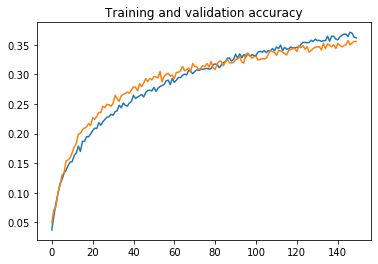

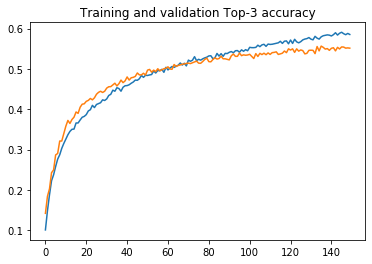

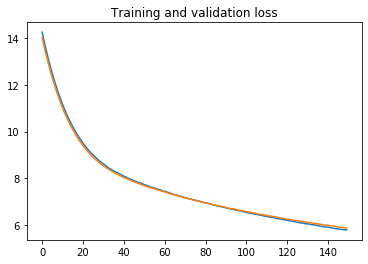

In [26]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = historycnn.history['accuracy']
val_acc = historycnn.history['val_accuracy']
top3acc = historycnn.history['top3_accuracy']
val_top3acc = historycnn.history['val_top3_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = historycnn.history['loss']
val_loss = historycnn.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, top3acc)
plt.plot(epochs, val_top3acc)
plt.title('Training and validation Top-3 accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [27]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


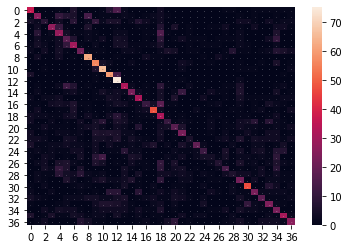

In [28]:
#generating heatmap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, y_pred)
f = sns.heatmap(cm, annot=True, annot_kws={"size": 1})

In [29]:
#printing model performance wrt defined metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_generator.classes, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(test_generator.classes, y_pred, average='weighted')))

category_names=sorted(os.listdir('G:/btp data/Resized/top 400/exp3/train/'))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=category_names))


Accuracy: 0.35

Micro Precision: 0.35
Micro Recall: 0.35
Micro F1-score: 0.35

Macro Precision: 0.34
Macro Recall: 0.35
Macro F1-score: 0.32

Weighted Precision: 0.34
Weighted Recall: 0.35
Weighted F1-score: 0.32

Classification Report

                            precision    recall  f1-score   support

            Albrecht Durer       0.42      0.46      0.44        80
             Alfred Sisley       0.35      0.33      0.34        80
           Boris Kustodiev       0.16      0.10      0.12        80
             Camille Corot       0.48      0.34      0.40        80
          Camille Pissarro       0.25      0.35      0.29        80
             Childe Hassam       0.16      0.21      0.18        80
              Claude Monet       0.28      0.38      0.32        80
               Edgar Degas       0.29      0.26      0.28        80
             Eugene Boudin       0.55      0.78      0.64        80
              Eyvind Earle       0.41      0.70      0.52        80
             